# **Exploratory data analysis for the `Arts and Crafts` Amazon dataset**

In this project, I had a target to check the content of retail product reviews dataset and see some patterns which can be interesting and potentially lead to some business decesions.

  I have chosen the dataset, located at https://nijianmo.github.io/amazon/index.html, which represents the 494485 reviews of the Amazon users in the category "Arts, Crafts and Sewing" for the years from March 2004 to October 2018. The dataset is reduced, which means it contains only the products with at least 5 reviews in each. 

##Exploratory data analysis.

To start with, let's load the libraries:

In [1]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import matplotlib 
from bs4 import BeautifulSoup
import re

Now, let's load the data from `gzip` file to the Pandas dataframe.

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

file_path = 'Arts_Crafts_and_Sewing_5.json.gz'
i = 0
data = {}
for d in parse(file_path):
  data[i] = d
  i += 1

arts = pd.DataFrame.from_dict(data, orient='index')


Let's check content of the dataset.

In [3]:
arts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494485 entries, 0 to 494484
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         494485 non-null  float64
 1   verified        494485 non-null  bool   
 2   reviewTime      494485 non-null  object 
 3   reviewerID      494485 non-null  object 
 4   asin            494485 non-null  object 
 5   style           233134 non-null  object 
 6   reviewerName    494443 non-null  object 
 7   reviewText      494196 non-null  object 
 8   summary         494362 non-null  object 
 9   unixReviewTime  494485 non-null  int64  
 10  vote            71015 non-null   object 
 11  image           10789 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 45.7+ MB


The dataset contains following columns:
- `overall`. Represents the rating score given by the user to the item during review. The values are from 1 to 5
- `verified`. If the review is verified (True/False)
- `reviewTime`. The date when the review is done (MM DD, YYYY)
- `reviewerID`. ID of the user made the review
- `asin`. ID of the product
- `style`. Dictionary of product metadata, for instance the color, type of cover, etc.
- `reviewerName`. Name of the user
- `reviewText`. The text of review itself
- `summary`. The header of the review
- `unixReviewTime`. Unix time of the review 
- `vote`. How many other users found this review helpful
- `image`. The images, loaded by user for the review (link to image or list of links).

I will convert the type of the `reviewerName`, `summary`, `asin` and `reviewText` to string format, and reviewTime to date format.

In [4]:
arts.reviewerID.astype('string')
arts.reviewText.astype('string')
arts.summary.astype('string')
arts.asin.astype('string')
arts.reviewTime=pd.to_datetime(arts.reviewTime) 

If we will inspect how many users left the reviews, it will appear that there was 56210 users left the reviews for 22931 items.

In [5]:
print("Unique users", len(arts.reviewerID.unique()))
print("Unique items", len(arts.asin.unique()))

Unique users 56210
Unique items 22931


Number of users with number of reviews more than 50 is: 226


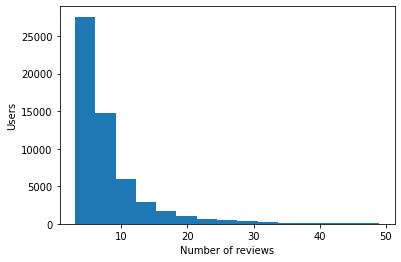

In [6]:
reviews_users=arts[["reviewerID", "asin"]]
count_reviews=reviews_users.groupby(['reviewerID']).count()
reviews_users=pd.DataFrame({"users": count_reviews.index, "review_num":count_reviews["asin"]})
reviews_users=reviews_users.sort_values(by=['review_num'], ascending=False).reset_index(drop=True)

#Plot of relation of number of reviews per 1 user
plt.hist(reviews_users.review_num[reviews_users.review_num < 50], density=False, bins=15)  # density=False would make counts
plt.ylabel('Users')
plt.xlabel('Number of reviews');

print("Number of users with number of reviews more than 50 is:", len(reviews_users.review_num[reviews_users.review_num>50]))

From the plot above, it is visible, that most of the users left less than 20 reviews, and only 226 users out of 56210 left over 50 reviews. That may be some bulk purchasing companies which most probably buy huge number of positions per period of time and so leaving so many reviews. In case if I would have some more data, I would explore this dependency more, as it can happen to be some suspicious user activity. 

If we will look at the dataset info, we will see that not all the users who put the rating, left the review text or the summary. 
Number of reviews, containing images is almost 50 times smaller than overall number of reviews. 
Also, we will see that half of the review is lacking `style` input, and almost 85% of reviews do not have votes. 

In [7]:
arts.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             261351
reviewerName          42
reviewText           289
summary              123
unixReviewTime         0
vote              423470
image             483696
dtype: int64

Let's check, for which kind of rates the votes and the missing review text and summary present.

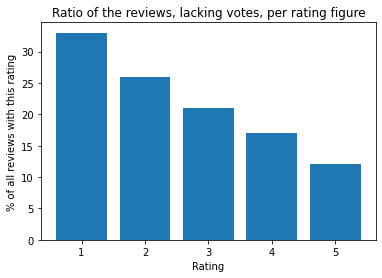

In [8]:
#Ratio in % of the reviews in each rate category, which have "vote" field empty:
arts.overall[arts.vote.isnull()].value_counts()
vote_empty=round(((arts.overall.value_counts()-arts.overall[arts.vote.isnull()].value_counts())/arts.overall.value_counts())*100)

plt.bar(vote_empty.index, vote_empty)
plt.title('Ratio of the reviews, lacking votes, per rating figure')
plt.xlabel('Rating')
plt.ylabel('% of all reviews with this rating')
plt.show()

In [9]:
#Ratio of the "5.0" reviews among the reviews which have "reviewText" field empty:
arts.overall[arts.reviewText.isnull()].value_counts()
(arts.overall[arts.reviewText.isnull()].value_counts()[5]/arts.overall[arts.reviewText.isnull()].value_counts().sum())

0.889273356401384

In [10]:
#Ratio of the "5.0" reviews among the reviews  which have "summary" field empty:
arts.overall[arts.summary.isnull()].value_counts()
arts.overall[arts.summary.isnull()].value_counts()[5]/arts.overall[arts.summary.isnull()].value_counts().sum()

0.8536585365853658

It is interesting, that for the votes, the less the rate of the review, the bigger ratio of votes for that review. For instance, for '1.0' and '2.0' ratings 33% and 25% of reviews respectively contain votes. It looks like the users who are completely dissatisfied by the product quality, prefer to click a vote button than leave a review. In case if there will be a research for certain products quality, it is better to include the votes as additional reviews without a text but with corresponding rate. 

At the same time with the text of review and summary the situation is the opposite. The largest amount of the rates without review text or summary go with '5.0' rate (89% and 85% correspoindingly). 

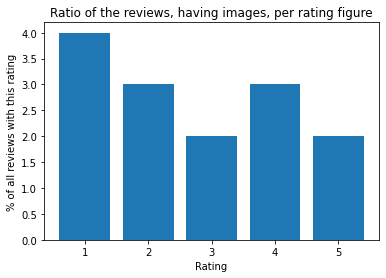

In [11]:
#Ratio in % of the reviews in each rate category, which have "image" field non-empty:
arts.overall[arts.image.isnull()].value_counts()
image_present=round(((arts.overall.value_counts()-arts.overall[arts.image.isnull()].value_counts())/arts.overall.value_counts())*100)

plt.bar(image_present.index, image_present)
plt.title('Ratio of the reviews, having images, per rating figure')
plt.xlabel('Rating')
plt.ylabel('% of all reviews with this rating')
plt.show()

For the images, the users added them with the similar frequency for whatever rate they put to the review. However, you can see that the highest number of pictures go with the lowest rating (1.0), so most probably users are mostly showing the defects which they spotted on the posted pictures. And as you can see, the number of review, containing images, is just 2-4% of overall reviews number.

We can see in the `style` field, that only half of the reviews contain information about the style. I have parsed the column to get all the style categories, which are being mentioned, and found out that it is naturally everything - from the color of the goods to the package properties. Having in mind the number of categories and number of possible values in each of them, I skipped making the analysis of the ratings per styling category. 

In [12]:
styles=arts['style'].tolist()

for i in range(len(styles)):
    if  pd.isna(styles[i]):
        styles[i]={}
set().union(*styles)
styles_d = {style_type: [s.get(style_type) for s in styles] for style_type in set().union(*styles) }
print(styles_d.keys())

dict_keys(['Product Packaging:', 'Size:', 'Overall Length:', 'Color:', 'Design:', 'Material Type:', 'Package Type:', 'Scent:', 'Pattern:', 'Color Name:', 'Scent Name:', 'Size Name:', 'Display Height:', 'Item Package Quantity:', 'Style Name:', 'Item Display Length:', 'Format:', 'Edition:', 'Material:', 'Number of Items:', 'Length:', 'style name:', 'Style:', 'Package Quantity:'])


I'm going to skip analysing the column `unixReviewTime` as we have already `reviewTime` and column `verified`, as most of the rows of the `verified` have "True" value, so this column will not carry significant info. 

Let's see what's the split of the review per rates:

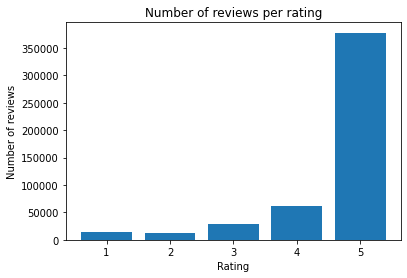

In [13]:
rate_counts=arts.overall.value_counts()

plt.bar(rate_counts.index, rate_counts)
plt.title('Number of reviews per rating')
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.show()

In [14]:
arts.overall.value_counts()[5]/arts.overall.value_counts().sum()

0.7635620898510571

If we will look at the distribution of the ratings, we will see that the dataset is very much skewed towards the "5.0" rating. Cumulative count of all the rest of the rates is lower than the number of rates with rating "5.0". During modeling, we will need to take into account this imbalance.  

I have checked several other Amazon dataset categories on the same resource, and appeared that this pattern is similar at least for part of them (for instance, 'Digital Music' and 'Video Games'). The skew for the category 'Appliances' was much lower. This may mean that the people tend to have good emotions about their hobby for which they purchase some materials and so more often put high rates, or have more information about the product in the item description and less hidden features which worked not as expected and revealed later during use. That investigation can be done only with more product information at hand.   

The reviews in the dataset can be observed in the following time interval:

In [15]:
print(min(arts.reviewTime))
print(max(arts.reviewTime))

2004-05-16 00:00:00
2018-10-03 00:00:00


Let's see how the number of reviews is distributed over time in this dataset.

In [16]:
review_over_time=arts[["reviewTime", "overall"]]
count_rate=review_over_time.groupby(['reviewTime']).count()

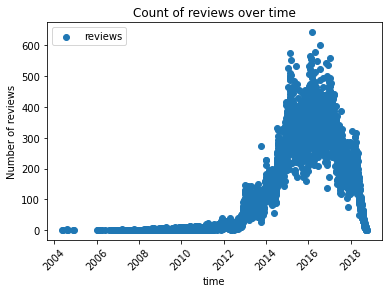

In [17]:
date=list(count_rate[["overall"]].index.values)
count=count_rate[["overall"]]
plt.scatter(date, count, label="reviews")
plt.title("Count of reviews over time")
plt.xlabel("time")
plt.ylabel("Number of reviews")
plt.legend()
plt.xticks(rotation=45)

plt.show()

It is seen from the graph above, that the number of reviews per day did not exceed 10-20 before 2013, while after that time it started to grow almost exponentially. The peak of the review numbers came at 2016, and it declined drastically (almost to the initial minimum) to the end of the observation period. It can happen, that due to the time distribution specifics, it will worth to take only part of the reviews between 2015 and 2018 for modeling, as the reviews out of this time range may differ by some parameters from any other period in this dataset.

The next test I want to do is to define, whether the number of words in the review anyhow corresponds to the rating, the user gave to the certain item.

First, I will clean the column `reviewText` from the html links and count the words, recording it to the separate list. Then, I will create a dataframe with the ratings and the count of words, and plot the relation between them.

In [18]:
text_df=arts[["reviewText", "overall"]]
text_df=text_df.dropna()
word_count=[]

for review in text_df["reviewText"]:
    
    #Removing HTML tags from reviews
    review_clean = BeautifulSoup(review).get_text()

    #Removing all punctuation signs from the text, replacing it with spaces 
    review_clean = re.sub("[^a-zA-Z0-9']"," ",review_clean)
    
    #Splitting review into words and recording the count
    wcount=len(review_clean.split())
    word_count.append(wcount)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://images-na.ssl-images-amazon.com/images/I/41c-Ua-m7UL._SS300_.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/Cant-Believe-Knitting-Socks-Leisure/dp/1601402503?ie=UTF8&redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_2" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://images-na.ssl-images-amazon.com/images/I/41r58yR2r0L._SS300_.jpg" looks like a URL. Beau

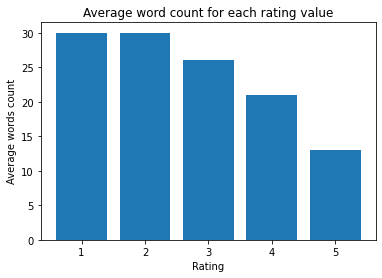

In [19]:
text_df["word_count"]=word_count
count_a=text_df.groupby(['overall']).median()

plt.bar(count_a.index, count_a.word_count)
plt.title("Average word count for each rating value")
plt.xlabel("Rating")
plt.ylabel("Average words count")

plt.show()

We can see from the plot above, that the users, giving lower ratings, tend to give more explanations on them, while the high ratings tend to have much less words per review. I have chosen `median` metric for this plot, as I have identified that there are some outliers, which can produce different results for 5.0 reviews in case of using `mean` metric, which is more sensitive to outliers. 

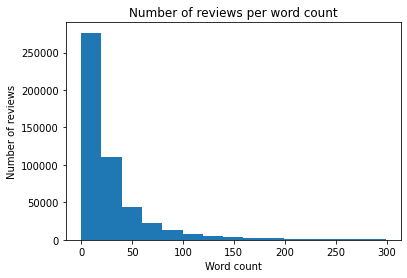

In [20]:
plt.hist(text_df.word_count[text_df.word_count<300], bins=15)
plt.title("Number of reviews per word count")
plt.xlabel("Word count")
plt.ylabel("Number of reviews")

plt.show()

Majority of the reviews have the length less than 100 words, and as we could see on the previous plot, the average length of the review is not higher than 30 words for any rating category. Here is the number of outliers, which have the larger number of words per review than 300 and which is less than 1% from the overall number of reviews: 

In [26]:
print("The number of reviews with the words count more than 300 is:", len(text_df.word_count[text_df.word_count>300]), round(len(text_df.word_count[text_df.word_count>300])*100/len(text_df.word_count),2), "% from total reviews")
print("The number of reviews with the words count less or equal than 2 is:", len(text_df.word_count[text_df.word_count<3]), round(len(text_df.word_count[text_df.word_count<3])*100/len(text_df.word_count),2), "% from total reviews")

The number of reviews with the words count more than 300 is: 3129 0.63 % from total reviews
The number of reviews with the words count less or equal than 2 is: 66119 13.38 % from total reviews


As we can see, the number of reviews with more than 300 words is really neglible, while the number of reviews like "five stars", "four stars", having just 2 words, is 13.28%, which is significant. That probably can not degrade the classification accuracy, but this definitely will degrade explainability of the review, as suggested in the reference article, built on that dataset. 

References:
1. "Justifying recommendations using distantly-labeled reviews and fined-grained aspects", Jianmo Ni, Jiacheng Li, Julian McAuley. Empirical Methods in Natural Language Processing (EMNLP), 2019